<a href="https://colab.research.google.com/github/mauriziobrt/schaeffer-dataset/blob/main/multilabel_audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi label classification of audio using distillhubert

In [ ]:
#@title STEP 0 - Install the required libs
%%bash
pip install datasets evaluate
pip install git+https://github.com/huggingface/accelerate
pip install --upgrade transformers

In [ ]:
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

In [ ]:
#@title STEP 1 - import the required libs

from datasets import load_dataset, Audio
import numpy as np
import json
import pandas as pd
import os
import gc
from io import StringIO
from transformers import DataCollatorWithPadding
import torch
from transformers import AutoModelForAudioClassification



In [ ]:
#@title STEP 2 - login into huggingface if required (if HFTOKEN has been set, you can skip this part)

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#@title If too much ram is being used, press here to free it
gc.collect()

In [ ]:
#@title STEP 3a - Prepare and load the dataset ([Audio(), classes])
# params
dataset_huggingface_link = "dbschaeffer/schaeffer_thesis_corrected" # @param {type:"string"}
csv_with_classes = "labels.json" # @param {type:"string"}
class_to_train = 'Type' # @param ['Processes', 'PulseTypology', 'Complexity', 'Onset', 'Offset', 'Type', 'MassType', 'Directionality']
dataset = load_dataset(dataset_huggingface_link)
sample_rate_master = 16000 # @param {type:"number"}

#IMPORTANT LOAD THE LABELS.JSON FILE
df = pd.read_json(csv_with_classes)
df = df[class_to_train]
df = df.dropna()
type_array = df.to_numpy()
#print(type_array)
def preprocess_function_type(examples):
  input = {}
  type_arr = [False] * (len(type_array)+1)
  for x, idx in enumerate(type_array):
    #print(type_array[x], examples[class_to_train])
    if type_array[x] in examples[class_to_train]:
      type_arr[x+1] = True
      #print(idx)
      #input[idx] = type_arr[x+1]
    input[idx] = type_arr[x+1]
  return input

list_names = dataset["train"].column_names
list_names = list_names[1:]

data_type = dataset["train"].map(
    preprocess_function_type,
    remove_columns= list_names,
    batched=False,
    batch_size=1,
    num_proc=1,
)
#Split dataset in training set and test set with shuffle
#Create function for label to id and back
labels = [label for label in data_type.features.keys() if label not in ['audio']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

data_type = data_type.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
#@title STEP 3B - If you already have a dataset skip step 3A and 5

data_encoded = load_dataset("dbschaeffer/schaeffer_thesis_processes")

In [ ]:
#@title STEP 4 - Load Feature Extractor

from transformers import AutoFeatureExtractor
from datasets import Audio

#model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
#feature_extractor = AutoFeatureExtractor.from_pretrained(model_audio)
max_duration = 10.0

model_id = "ntu-spml/distilhubert"

#the feature extractor will build an attention mask and normalize data
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True, padding= True, max_length = sample_rate_master * max_duration, return_tensors="pt"
)
#this set the sampling rate to the one needed for the model
sampling_rate = feature_extractor.sampling_rate
#This resamples the audio to model sampling rate
#data_split = data_split.cast_column("audio", Audio(sampling_rate=sampling_rate))
transformers_data_collator = DataCollatorWithPadding(tokenizer=feature_extractor)

In [ ]:
# @title STEP 5 - Preprocess
## @markdown Press to start preprocess, preparing the dataset for training.

#dataset_for_preprocess = data_split
max_duration = 10.0

#from transformers import AutoFeatureExtractor
#model_audio = "MIT/ast-finetuned-audioset-10-10-0.4593"
#feature_extractor = AutoFeatureExtractor.from_pretrained(model_audio)

max_length=int(feature_extractor.sampling_rate * max_duration)

def preprocess_function(examples):
  #print(max(examples["audio"]["array"]))
  #audio_arrays = [x["array"] for x in examples["audio"]]
  inputs = feature_extractor(
        examples["audio"]["array"],
        padding='max_length',
        truncation=True,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        return_attention_mask=True,
  )

  # Labels Preprocessing
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  #create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((1, len(labels)))
  #fill numpy array
  for idx, label in enumerate(labels):
      labels_matrix[:, idx] = labels_batch[label]
      inputs["label"] = labels_matrix.tolist()
  return inputs

data_encoded = data_type.map(
    preprocess_function,
    remove_columns=data_type.column_names,
    batched=False,
    batch_size=1,
    num_proc=1,
)

data_encoded.set_format("torch")

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

In [ ]:
#@title STEP 6 - Load HF model
#model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(id2label),
    label2id=label2id,
    id2label=id2label,
    output_hidden_states=True
    #ignore_mismatched_sizes=True,
)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#@title STEP 7 - Set Trainer Arguments

from transformers import TrainingArguments, Trainer

model_name = model_id.split("/")[-1]
batch_size = 1
gradient_accumulation_steps = 1
num_train_epochs = 20
metric_name = "f1"

training_args = TrainingArguments(
    f"{model_name}-finetuned-multi-label" + "_" + class_to_train,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    fp16=True,
    push_to_hub=True,
)

In [ ]:
#@title STEP 8 - Set Metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.3):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    #print("Predictions: ",probs, "Predictions shape: ",probs.shape)
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    #print(probs)
    #y_pred = y_pred.astype("int32")
    # finally, compute metrics
    y_true = labels.squeeze(1)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
#@title STEP 9 - Split Dataset into Test and Eval
data_encoded = data_encoded.train_test_split(seed=42, shuffle=True, test_size=0.1)

In [ ]:
data_encoded_train = data_encoded["train"]
data_encoded_eval = data_encoded["test"]

In [ ]:
#@title STEP 10 - Define Trainer loop

#Ensure that all data is moved to device and that the dataset is moved to torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data_encoded.set_format("torch")

from transformers import Trainer
def loss_fn(outputs, targets):
    #sigmoid = torch.nn.Sigmoid()
    #outputs = sigmoid(torch.Tensor(outputs))
    #print(outputs)
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(input_values=inputs['input_values'].squeeze(0).to(device),
                            attention_mask=inputs["attention_mask"].squeeze(0).to(device)
                            )
            loss = loss_fn(outputs['logits'], inputs['labels'].squeeze(0).to(device))
            return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=data_encoded_train,
    eval_dataset=data_encoded_eval,
    data_collator=transformers_data_collator,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
#@title Define Transforms
from torchaudio.transforms import SpeedPerturbation

data_encoded_train.set_format("torch")

def peak_normalize(tensor):
    tensor /= torch.max(torch.abs(tensor))
    return tensor

def trim_pad_zeros(file, sample_rate):
    #I have an array of size = max value possible
    length_pad = sample_rate * 10
    fl_length = list(file.size())
    #the pad is equal to the max length - the file length and then applied at the end
    pd_length = length_pad - fl_length[2]
    split_length = length_pad
    if pd_length > 0:
        p = torch.nn.ConstantPad1d((0,pd_length), 0)
        file = p(file)
    else:
        #if file exceed max length, then pd_length is negative, so we split the file at length pad
        file = torch.split(file, length_pad)[0]
    return file

sample_rate = sample_rate_master
#file = dataset["train"][650]["audio"]["array"]
speed_perturb = SpeedPerturbation(sample_rate_master, [0.9, 1.0, 1.2, 1.1, 1.0])

def transforms(examples):
    audio = examples["input_values"]
    audio = peak_normalize(torch.Tensor(audio))
    audio = speed_perturb(audio)[0]
    audio = trim_pad_zeros(audio, sample_rate)
    #print(audio.shape)
    examples["input_values"] = audio
    return examples

data_encoded_train.set_transform(transforms)

In [ ]:
import IPython.display as ipd
ipd.Audio(data_encoded_train[1]["input_values"].detach().cpu().numpy(), rate=16000)

In [ ]:
#@title STEP 11 - Run Training

trainer.train(resume_from_checkpoint=False)

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.554400,0.536034,0.209068,0.500000,0.000000
2,0.308100,0.355463,0.181818,0.543799,0.037975
3,0.293400,0.322649,0.171429,0.540164,0.050633
4,0.294400,0.319108,0.171429,0.540164,0.050633
5,0.265200,0.312555,0.171429,0.540164,0.050633
6,0.249100,0.309369,0.177419,0.542380,0.050633
7,0.340800,0.302782,0.213740,0.557267,0.063291
8,0.228700,0.298412,0.236162,0.567325,0.063291
9,0.272700,0.295538,0.313333,0.606933,0.037975


In [ ]:
#@title STEP 12 - Evaluate model
evaluated = trainer.evaluate()

In [ ]:
evaluated

{'eval_loss': 0.3984854519367218,
 'eval_f1': 0.5,
 'eval_roc_auc': 0.6965604238499706,
 'eval_accuracy': 0.17721518987341772,
 'eval_runtime': 1.8255,
 'eval_samples_per_second': 43.277,
 'eval_steps_per_second': 43.277,
 'epoch': 20.0}

In [ ]:
#@title STEP 13 - Try a forward pass
import IPython.display as ipd

def logits2labeldict(logits):
  logits = logits.to("cpu")
  logits_dict = {}
  test_logit = logits.numpy()
  for idx, label in enumerate(labels):
    if test_logit[0][idx] > 0.0:
      logits_dict[label] = test_logit[0][idx]
  return logits_dict

testing_set = "test"
testing_index = 5 #@param {type:"number"}
testing_label = data_encoded[testing_set][testing_index]["label"]
testing_audio = data_encoded[testing_set][testing_index]["input_values"]
testing_mask  = data_encoded[testing_set][testing_index]["attention_mask"]



from IPython.display import Audio

model.eval()

with torch.no_grad():
    inputs = testing_audio.to(device)
    #labels = batch['label'].to(device)
    attention_mask = testing_mask.to(device)
    attention_mask = attention_mask.float()

    # Forward pass
    outputs = model(inputs, attention_mask)
    logits = outputs.logits
    logits = torch.sigmoid(logits)
    logits_pred = np.zeros(logits.shape)
    logits_pred[np.where(logits.cpu() >= 0.3)] = 1

    print("Predicted labels:", logits2labeldict(torch.tensor(logits_pred)))

print("Correct label: ", logits2labeldict(data_encoded[testing_set][testing_index]["label"]))
ipd.Audio(testing_audio, rate=16000)


Predicted labels: {'Granular': 1.0}
Correct label:  {'Reverb': 1.0, 'Filtered': 1.0}


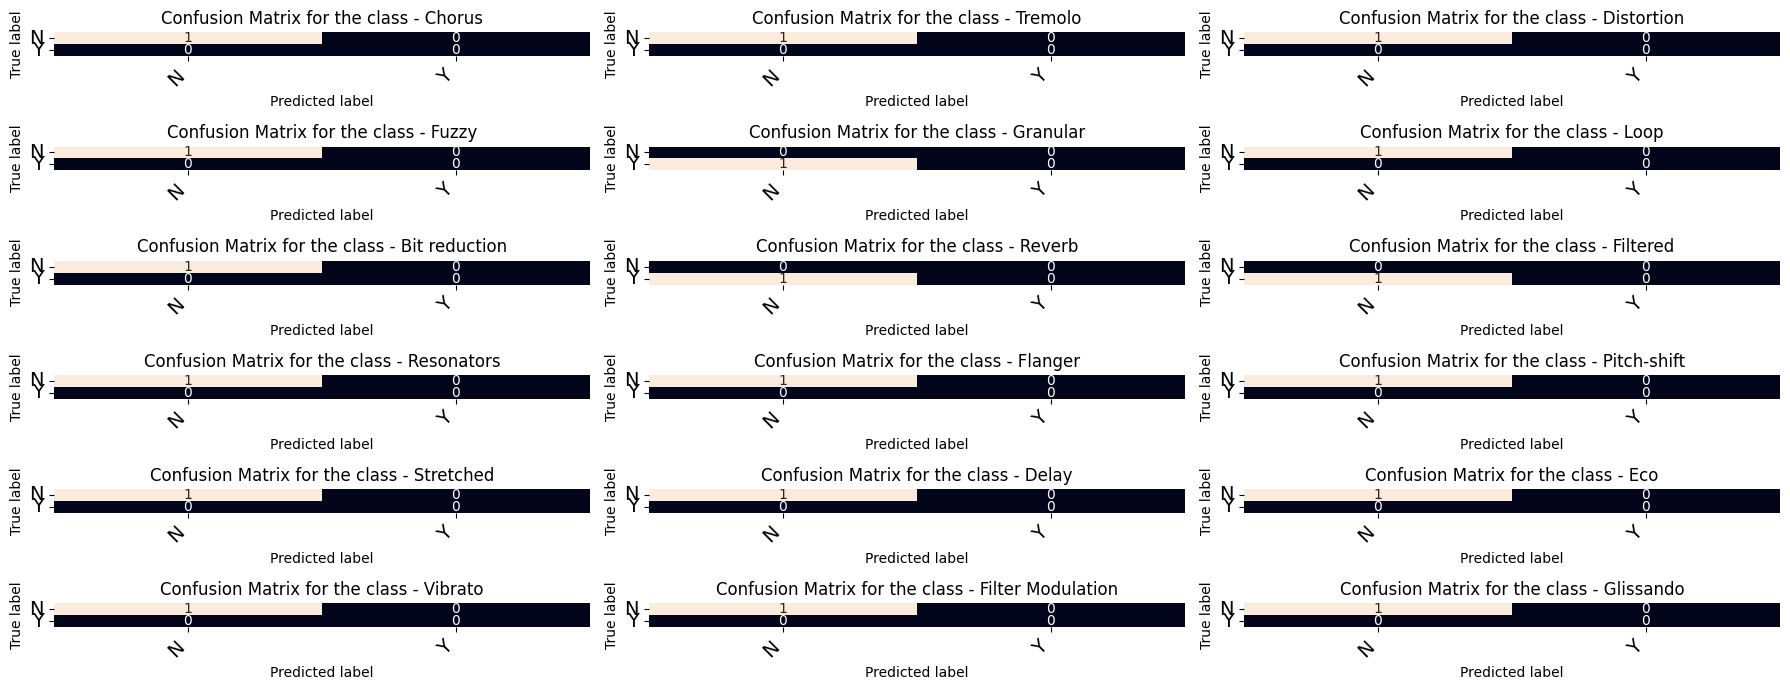

In [ ]:
#@title STEP 14 - Calculate confusion matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
labels = [key for key in id2label.values()]

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt

y_pred = np.zeros(logits.shape)
y_pred[np.where(logits.cpu() >= 0.3)] = 1
y_test = testing_label.cpu().detach().numpy()

cm = multilabel_confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(6, 3, figsize=(18, 7))

for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [ ]:
trainer.save_model("path_to_save")

# to put in order

## Try a forward pass

In [ ]:
input_values, labels, attention_mask = data_encoded['train']['input_values'][2],data_encoded['train']['label'][2],data_encoded['train']['attention_mask'][2]
input_values, labels, attention_mask = input_values.to(device), labels.to(device), attention_mask.to(device)

In [ ]:
print(attention_mask.size(), input_values.size(), labels.size())

torch.Size([1, 160000]) torch.Size([1, 160000]) torch.Size([1, 18])


In [ ]:
logits = model(input_values)
logits["logits"]#.size()

tensor([[-0.0383,  0.0981,  0.0082,  0.0623, -0.0135, -0.0188, -0.0729,  0.0400,
         -0.0688,  0.0268,  0.0214, -0.0070, -0.0539, -0.0027, -0.0005,  0.0445,
         -0.0161,  0.0760]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(logits["logits"], labels)
loss

tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
outputs = model(input_values, attention_mask=attention_mask)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0383,  0.0981,  0.0082,  0.0623, -0.0135, -0.0188, -0.0729,  0.0400,
         -0.0688,  0.0268,  0.0214, -0.0070, -0.0539, -0.0027, -0.0005,  0.0445,
         -0.0161,  0.0760]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=(tensor([[[-0.4525,  0.0728, -0.1603,  ...,  0.5892, -0.0867,  0.0671],
         [-0.1353,  0.1419, -0.0170,  ...,  0.4192, -0.5979,  0.7432],
         [-0.2993, -0.0172, -0.0388,  ...,  0.3356, -0.3881,  0.8582],
         ...,
         [-0.1529,  0.2072,  0.0307,  ...,  0.1435, -0.1257,  0.6413],
         [-0.2053,  0.2279,  0.0950,  ...,  0.1243, -0.1295,  0.8651],
         [-0.2758,  0.2653,  0.2355,  ...,  0.0549, -0.1763,  1.2920]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), tensor([[[-0.0205,  0.3913, -0.0615,  ...,  0.0024,  0.1011, -0.2587],
         [-0.0635,  0.4114, -0.0138,  ..., -0.0892, -0.0192,  0.1721],
         [ 0.0411,  0.2558, -0.2233,  ...,  0.0028,  0.0710,  

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForAudioClassification
from torch.utils.data import DataLoader, TensorDataset

# Sample data (replace this with your own data)
texts = ["Sample text 1", "Sample text 2", "Sample text 3", "Sample text 4", "Sample text 5"]
labels = [[1, 0, 1], [0, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1]]  # Example multilabel labels

# Load pre-trained BERT model and tokenizer
#model_name = "bert-base-uncased"
#tokenizer = BertTokenizer.from_pretrained(model_name)
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=18)
#model_id = "ntu-spml/distilhubert"

# Tokenize input texts
#tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Convert labels to torch tensor
#labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Create DataLoader
#dataset = TensorDataset(tokenized_texts["input_ids"], tokenized_texts["attention_mask"], labels_tensor)
dataset = TensorDataset(data_encoded["train"]["input_values"], data_encoded["train"]["attention_mask"], data_encoded["train"]["label"])
batch_size = 3  # Adjust the batch size as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example forward pass
for batch in dataloader:
    input_ids, attention_mask, batch_labels = batch
    outputs = model(input_ids, batch_labels)

    # Your custom code for loss calculation, backpropagation, and optimization goes here


## Training part

In [ ]:
gc.collect()

In [ ]:
input_dataset = data_encoded["train"]["input_values"]
label_dataset = data_encoded["train"]["label"]
attention_dataset = data_encoded["train"]["attention_mask"]
input_dataset = input_dataset.to(device)
label_dataset = label_dataset.to(device)
attention_dataset = attention_dataset.to(device)

Test: datacollator

## Working
Though i don't understand if i have to pass the labels to the model or i just pass them to the loss function

{'eval_loss': 0.3404619097709656,
 'eval_f1': 0.39349593495934954,
 'eval_roc_auc': 0.6694312090530078,
 'eval_accuracy': 0.2846715328467153,
 'eval_runtime': 5.3385,
 'eval_samples_per_second': 25.663,
 'eval_steps_per_second': 25.663,
 'epoch': 20.0}

In [ ]:
results = []
results.append(evaluated)

In [ ]:
results

[{'eval_loss': 0.6956783533096313,
  'eval_f1': 0.32710280373831774,
  'eval_roc_auc': 0.6031182344837029,
  'eval_accuracy': 0.2,
  'eval_runtime': 1.3774,
  'eval_samples_per_second': 39.93,
  'eval_steps_per_second': 39.93,
  'epoch': 20.0}]

In [ ]:
models = [model_id]

In [ ]:
df = pd.DataFrame(results, index=models)
df

,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
ntu-spml/distilhubert,0.340462,0.393496,0.669431,0.284672,5.3385,25.663,25.663,20.0


## Working
Also here I don't pass the labels to the model, but I have 18 logits and pass them to the loss function

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

training_loader = DataLoader(data_encoded["train"], batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(data_encoded["test"], batch_size=batch_size, shuffle=True)

In [ ]:
labels

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
#from torch.autograd import Variable
import torch.optim as optim
# Your model, criterion, and optimizer initialization here
#dataset_1 = TensorDataset(data_encoded["train"]["input_values"], data_encoded["train"]["attention_mask"], data_encoded["train"]["label"])

batch_size = 1  # Adjust the batch size as needed

training_loader = DataLoader(data_encoded["train"], batch_size=batch_size, shuffle=True)

#for i, x in enumerate(dataloader):
#    print(x.shape)
learning_rate = 0.001
criterion = torch.nn.BCEWithLogitsLoss()

#loss = criterion(logits["logits"], labels)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming you have a DataLoader named 'train_dataloader'
for batch in training_loader:
    #print(batch.keys())
    # Get input data and labels
    inputs = batch['input_values'].squeeze(0).to(device)
    labels = batch['label'].squeeze(0).to(device)
    attention_mask = batch["attention_mask"].squeeze(0).to(device)
    attention_mask = attention_mask.float()
    #print(inputs)
    # Forward pass
    outputs = model(inputs)
    #print(outputs)

    # Calculate the loss
    loss = criterion(outputs["logits"], labels)
    print(loss)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



In [ ]:
from tqdm import tqdm
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        #print(data.keys())
        input = data['input_values'].squeeze(0).to(device)
        mask = data['attention_mask'].squeeze(0).to(device)
        #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['label'].squeeze(0).to(device, dtype = torch.float)

        outputs = model(input, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs["logits"], targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
train(1)

2it [00:00, 12.08it/s]

Epoch: 1, Loss:  0.4532821476459503


1227it [01:31, 13.45it/s]


In [ ]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            input_array_squeezed = data['input_values'].squeeze(0).to(device)
            print(input_array_squeezed.shape)
            mask_array_squeezed = data['attention_mask'].squeeze(0).to(device)

            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['label'].squeeze(0).to(device, dtype = torch.float)

            outputs = model(input_array_squeezed, mask_array_squeezed)
            #print("AIUTO")

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs["logits"]).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5

0it [00:00, ?it/s]

torch.Size([3, 1, 160000])


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [3, 1, 1, 160000]

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
from sklearn import metrics
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.09090909090909091
Hamming Loss = 0.1383838383838384


## Inference

In [ ]:
PATH = "state_dict_model.pt"

In [ ]:
model.load_state_dict(torch.load(PATH),map_location=torch.device('cpu'))

In [ ]:
#torch.save(model.state_dict(), PATH)

In [ ]:
training_loader["input_values"]

Batch pass

In [ ]:
model.eval()

with torch.no_grad():
    for batch in testing_loader:
    #print(batch.keys())
    # Get input data and labels

      inputs = batch['input_values'].to(device)
      #labels = batch['label'].to(device)
      attention_mask = batch["attention_mask"].to(device)
      attention_mask = attention_mask.float()

      # Forward pass
      outputs = model(inputs, attention_mask)
      logits = outputs.logits
      print(logits)
      #print("Predicted class index:", logits.argmax(-1))

Single pass

Predicted labels: {'Distortion': 1.0, 'Granular': 1.0}


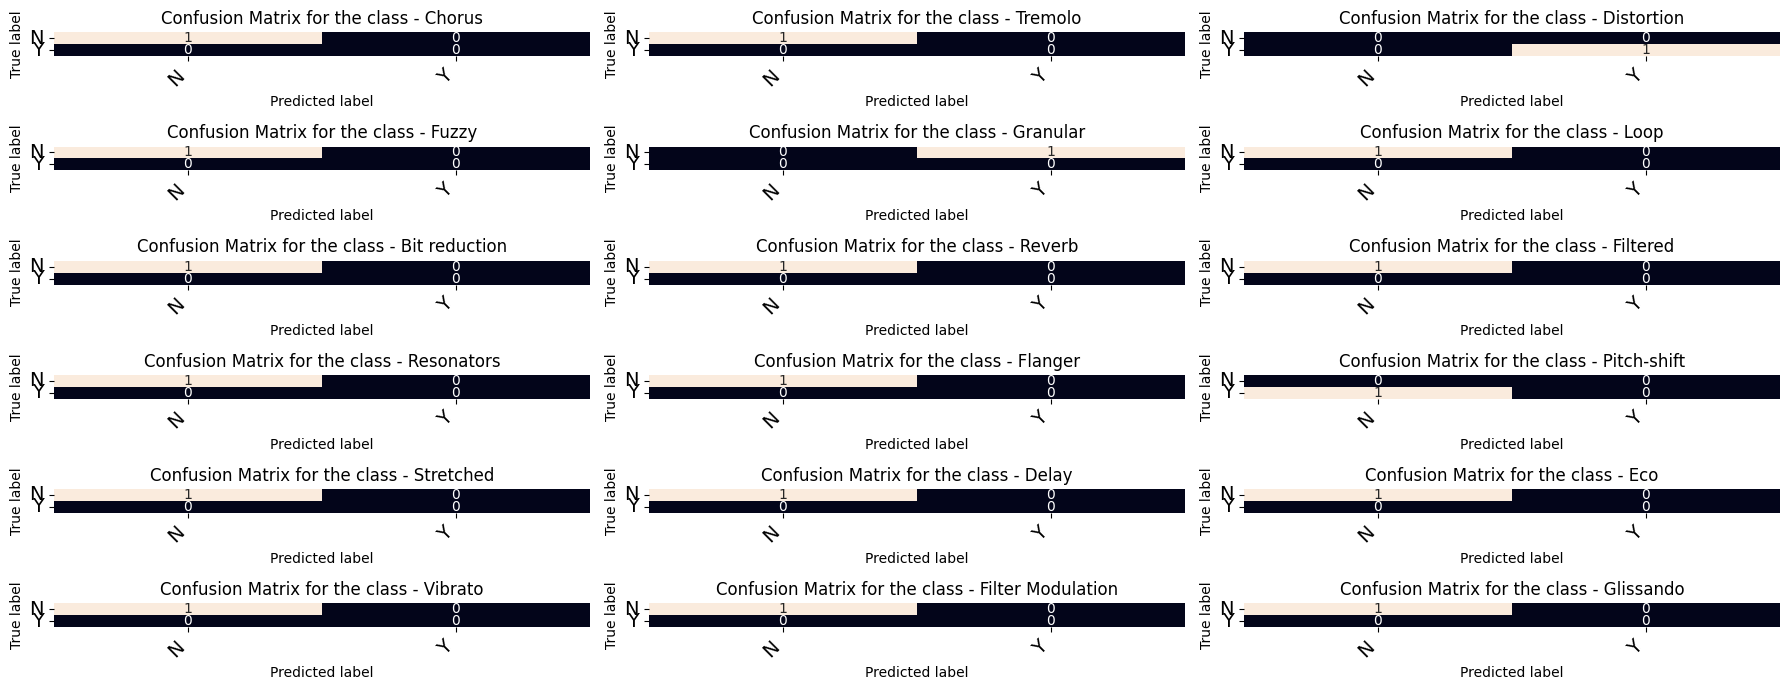

## Other stuff

In [ ]:
# Test with external audio
from IPython.display import Audio
import librosa

filename = "Giovanni Corgiat_ArcEmitter.wav"
external_audio, sr = librosa.load(filename, sr=16000)
external_audio_ts = torch.tensor(external_audio)

model.eval()

with torch.no_grad():
    inputs = external_audio_ts.unsqueeze(0).to(device)

    #labels = batch['label'].to(device)
    #attention_mask = testing_mask.unsqueeze(0).to(device)
    #attention_mask = attention_mask.float()
    audio_attention = feature_extractor(
        inputs,
        #padding='False',
        truncation=True,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        return_attention_mask=True,
    )
    # Forward pass
    outputs = model(inputs) #attention_mask)
    logits = outputs.logits
    logits = torch.sigmoid(logits)
    #print(logits)
    #print("Predicted class index:", logits.argmax(-1))
    df = pd.DataFrame(logits2labeldict(logits), index=[filename])

    print("Predicted labels:", logits2labeldict(logits))
    #print("Correct labels:", logits2labeldict(testing_label.unsqueeze(0)))


Audio(data=external_audio, rate=16000)

NameError: ignored

In [ ]:
df.sort_values(by=[filename], axis=1, ascending= False)

NameError: name 'filename' is not defined

In [ ]:
import gradio as gr
import librosa
def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32((s>>2)/(32768.0)) for s in SD])

def audio_classifier(inp):
    #print(inp[0])
    y = soundDataToFloat(inp[1])
    external_audio = librosa.resample(y,orig_sr=inp[0], target_sr=16000)
    external_audio = librosa.util.normalize(external_audio)
    external_audio_ts = torch.tensor(external_audio)

    model.eval()

    with torch.no_grad():
      inputs = external_audio_ts.unsqueeze(0).to(device)
      outputs = model(inputs)
      logits = outputs.logits
      logits = torch.sigmoid(logits)
    #print(logits2labeldict(logits))
    return logits2labeldict(logits)

demo = gr.Interface(fn=audio_classifier, inputs="audio", outputs="label")
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b8230c6661ccf8186d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7866 <> https://b8230c6661ccf8186d.gradio.live


## Save the model

In [ ]:
# Saving the files for inference

output_model_file = './pytorch_distilbert_news.bin'
output_vocab_file = './vocab_distilbert_news.bin'

torch.save(model.state_dict(), output_model_file)
feature_extractor.save_pretrained(output_vocab_file)

print('Saved')

Saved


In [ ]:
#map_location=torch.device('cpu')
model.load_state_dict(torch.load('./pytorch_distilbert_news.bin',  map_location=torch.device('cpu')))

NameError: ignored

In [ ]:
feature_extractor.from_pretrained('./vocab_distilbert_news.bin')

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

## Verify Mean and Variance using feature extractor

In [ ]:
import numpy as np

sample = data_split["train"][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

NameError: name 'data_split' is not defined

In [ ]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")

print(
    f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

inputs keys: ['input_values', 'attention_mask']
Mean: 5.48e-10, Variance: 0.98


## Cleanup

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Feb  4 14:54:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              29W /  70W |    219MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Optional: Data Augmentation

Depending on the classificatiion class it may be possible to change the augmentation processes.

In [ ]:
pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.4 MB/s eta 0:00:00


### Augment and concatenate

In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Normalize, AdjustDuration
import numpy as np
import librosa
#Dynamic time warping would be interesting for this scope

augment = Compose([
    Normalize(),
    PolarityInversion(p=0.5),
    #AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.005, p=0.15),
    TimeStretch(min_rate=0.8, max_rate=1.5, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.75),
    #PolarityInversion()
    AdjustDuration(duration_samples=sample_rate_master * 10, p=1.0)
])

def augment_function(examples):
  sr = sample_rate_master
  samples = np.float32(examples["audio"]["array"])
  augmented_samples = augment(samples=samples, sample_rate=sr)
  #copy_samples = augmented_samples.copy()
  #copy_samples.resize(sample_rate_master * 10)
  #print(copy_samples.shape)
  examples["audio"]["array"] = augmented_samples
  return examples

augmented_dataset = data_type.map(augment_function, batched=False)
#testing_audio =augment_function( data_split["train"][0])

Map:   0%|          | 0/788 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(


KeyboardInterrupt: 

Check if values resized are ok, also if the sound is still ok or fucked up

In [ ]:
from datasets import concatenate_datasets
total_dataset = concatenate_datasets([data_type, augmented_dataset])
data_split = total_dataset.train_test_split(seed=42, shuffle=True, test_size=0.1)

In [ ]:
import IPython.display as ipd
sr = sample_rate_master
test_audio = augmented_dataset["train"]["audio"][0]["path"]

ipd.Audio(test_audio, rate=sr)

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x7c5c811cc1f0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 1245, in vio_read
    buf = _ffi.buffer(ptr, count)
KeyboardInterrupt: 
